In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from time import time
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from scipy.stats import f
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm
from pmdarima import model_selection

In [2]:
#  Read the data and derive information about it
data = pd.read_excel('data_name_aqi.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1461 non-null   datetime64[ns]
 1   temperature           1452 non-null   float64       
 2   atmospheric_pressure  1452 non-null   float64       
 3   relative_humidity     1452 non-null   float64       
 4   precipitation         1461 non-null   float64       
 5   wind_speed            1452 non-null   float64       
 6   CO                    1461 non-null   float64       
 7   NO2                   1461 non-null   int64         
 8   O3                    1461 non-null   int64         
 9   PM10                  1461 non-null   int64         
 10  PM2.5                 1461 non-null   int64         
 11  SO2                   1461 non-null   int64         
 12  AQI                   1461 non-null   int64         
dtypes: datetime64[ns](

In [3]:
# Define the AQI levels and corresponding grades
aqi_levels = [0, 51, 101, 151, 201, 301]
grades = ['1', '2', '3', '4', '5', '6']

# Function to determine the grade based on AQI value
def determine_grade(aqi):
    for i in range(len(aqi_levels) - 1):
        if aqi_levels[i] <= aqi < aqi_levels[i+1]:
            return grades[i]
    return grades[-1]  # For AQI > 300

# Apply the function to create a new column 'Quality Levels'
data['Quality Levels'] = data['AQI'].apply(determine_grade)

# Display the first few rows of the updated data
print(data.head(7))

        date  temperature  atmospheric_pressure  relative_humidity  \
0 2020-01-01         -6.4                1028.2               39.0   
1 2020-01-02         -3.8                1027.3               43.0   
2 2020-01-03         -1.9                1025.0               50.0   
3 2020-01-04         -0.1                1024.4               48.0   
4 2020-01-05         -1.1                1027.2               75.0   
5 2020-01-06          0.3                1022.1               87.0   
6 2020-01-07          1.1                1021.7               39.0   

   precipitation  wind_speed    CO  NO2  O3  PM10  PM2.5  SO2  AQI  \
0            0.0         1.3  0.79   49  10    55     34    7   52   
1            0.0         1.0  1.18   63   9    79     51    7   70   
2            0.0         1.4  1.20   64  14    72     51    8   70   
3            0.0         1.0  1.08   59  21    66     42    7   61   
4            0.6         1.5  1.39   66   7    79     64    7   86   
5            4.1   

In [4]:
# Calculate missing values
missing_count = data.isnull().sum()
missing_percentage = data.isnull().mean() * 100 
valid_counts = data.notnull().sum()
missing_stats = pd.DataFrame({
    'Missing Count': missing_count, 
    'Missing Percentage': missing_percentage, 
    'Valid Counts': valid_counts
})
missing_stats

,Missing Count,Missing Percentage,Valid Counts
date,0,0.000000,1461
temperature,9,0.616016,1452
atmospheric_pressure,9,0.616016,1452
relative_humidity,9,0.616016,1452
precipitation,0,0.000000,1461
wind_speed,9,0.616016,1452
CO,0,0.000000,1461
NO2,0,0.000000,1461
O3,0,0.000000,1461
PM10,0,0.000000,1461


In [5]:
# 使用线性插值填充缺失值
data.interpolate(method='linear', inplace=True)

# 检查开头和结尾是否仍然有缺失值，并使用前向填充和后向填充处理
for column in data.columns:
    if pd.isnull(data[column].iloc[0]):
        data[column].iloc[0] = data[column].bfill().iloc[0]
    if pd.isnull(data[column].iloc[-1]):
        data[column].iloc[-1] = data[column].ffill().iloc[-1]

C:\Users\Liu\AppData\Local\Temp\ipykernel_15720\1707906975.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', inplace=True)


In [6]:
# Check for missing values
missing_count = data.isnull().sum()
print (missing_count)

date                    0
temperature             0
atmospheric_pressure    0
relative_humidity       0
precipitation           0
wind_speed              0
CO                      0
NO2                     0
O3                      0
PM10                    0
PM2.5                   0
SO2                     0
AQI                     0
Quality Levels          0
dtype: int64


In [7]:
print(data.columns)

Index(['date', 'temperature', 'atmospheric_pressure', 'relative_humidity',
       'precipitation', 'wind_speed', 'CO', 'NO2', 'O3', 'PM10', 'PM2.5',
       'SO2', 'AQI', 'Quality Levels'],
      dtype='object')


In [8]:
# 按年份分组数据
data['Year'] = data['date'].dt.year
normalized_2020 = data[data['Year'] == 2020].set_index('date')
normalized_2021 = data[data['Year'] == 2021].set_index('date')
normalized_2022 = data[data['Year'] == 2022].set_index('date')
normalized_2023 = data[data['Year'] == 2023].set_index('date')


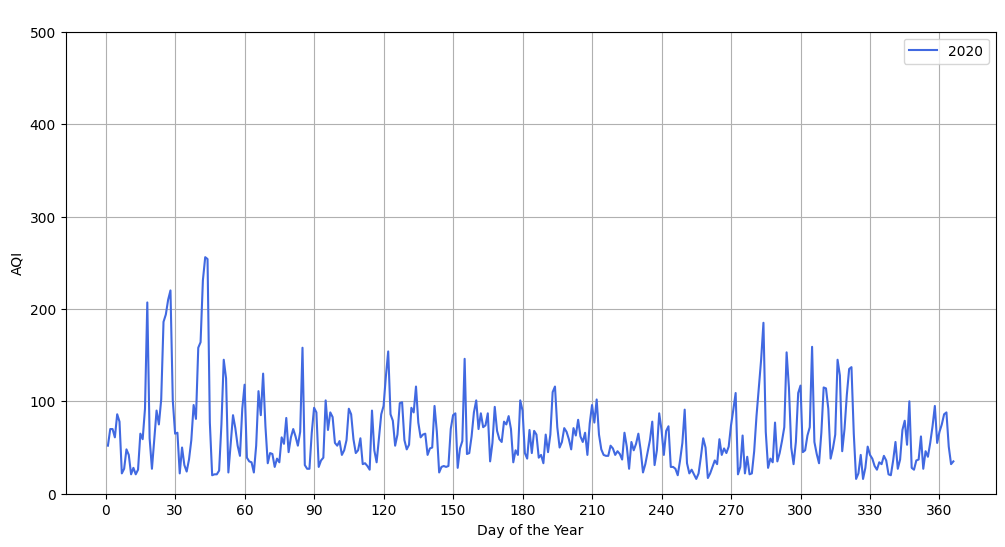

In [9]:

plt.figure(figsize=(12, 6))

plt.plot(normalized_2020.index.dayofyear, normalized_2020['AQI'], label='2020', color='royalblue')

plt.title(' ')
plt.xlabel('Day of the Year')
plt.ylabel('AQI')
plt.ylim(0, 500)  # 设置 y 轴范围
plt.legend()
plt.grid(True)
plt.xticks(range(0, 366, 30))  # 设置 x 轴刻度
output_path = 'C:/Users/Liu/Downloads/8_dissertation/2020.png'
plt.savefig(output_path)
plt.show()


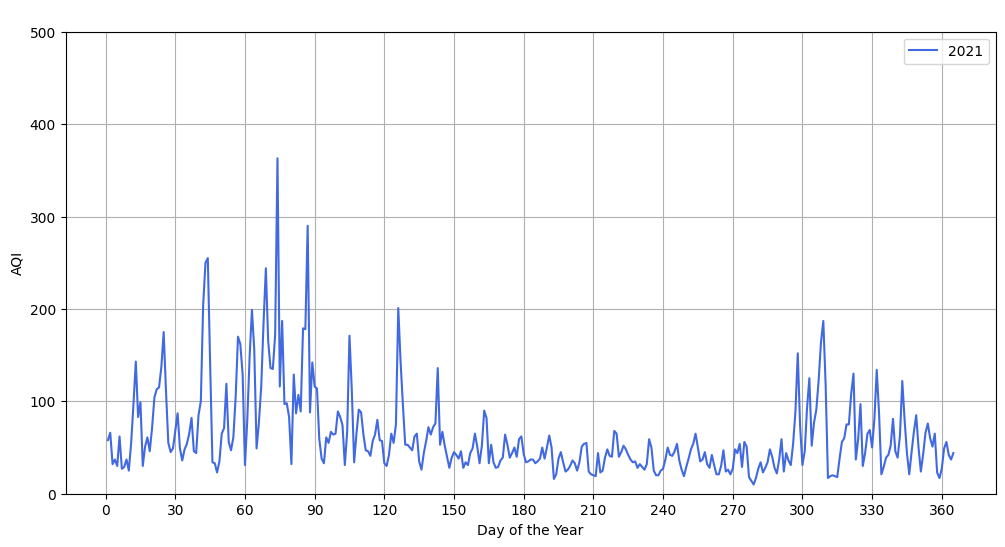

In [10]:
plt.figure(figsize=(12, 6))

plt.plot(normalized_2021.index.dayofyear, normalized_2021['AQI'], label='2021', color='royalblue')

plt.title(' ')
plt.xlabel('Day of the Year')
plt.ylabel('AQI')
plt.legend()
plt.ylim(0, 500) 
plt.grid(True)
output_path = 'C:/Users/Liu/Downloads/8_dissertation/2021.png'
plt.xticks(range(0, 366, 30))  # 设置x轴刻度显示每年的天数
plt.savefig(output_path)
plt.show()

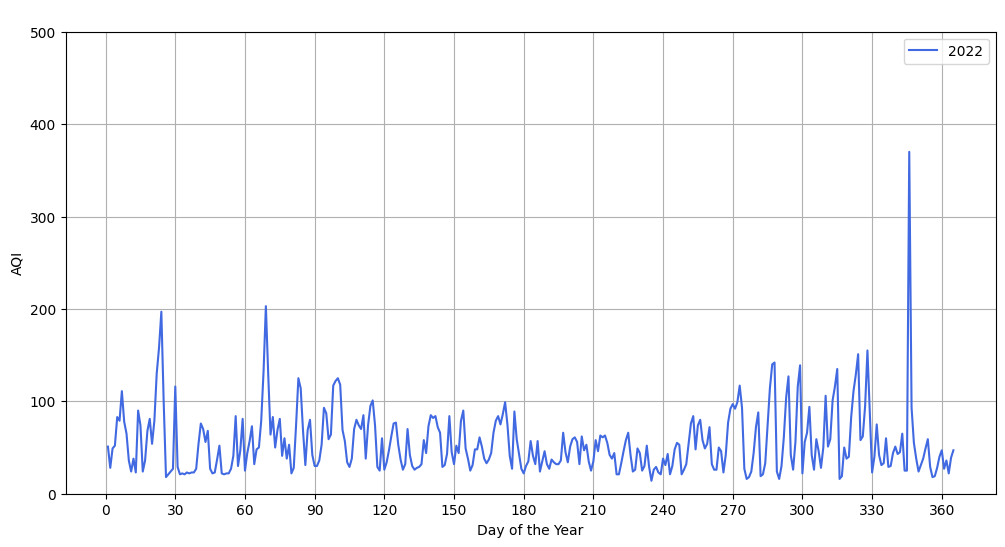

In [11]:
plt.figure(figsize=(12, 6))

plt.plot(normalized_2022.index.dayofyear, normalized_2022['AQI'], label='2022', color='royalblue')

plt.title(' ')
plt.xlabel('Day of the Year')
plt.ylabel('AQI')
plt.legend()
plt.ylim(0, 500) 
plt.grid(True)
output_path = 'C:/Users/Liu/Downloads/8_dissertation/2022.png'
plt.xticks(range(0, 366, 30))  # 设置x轴刻度显示每年的天数
plt.savefig(output_path)
plt.show()

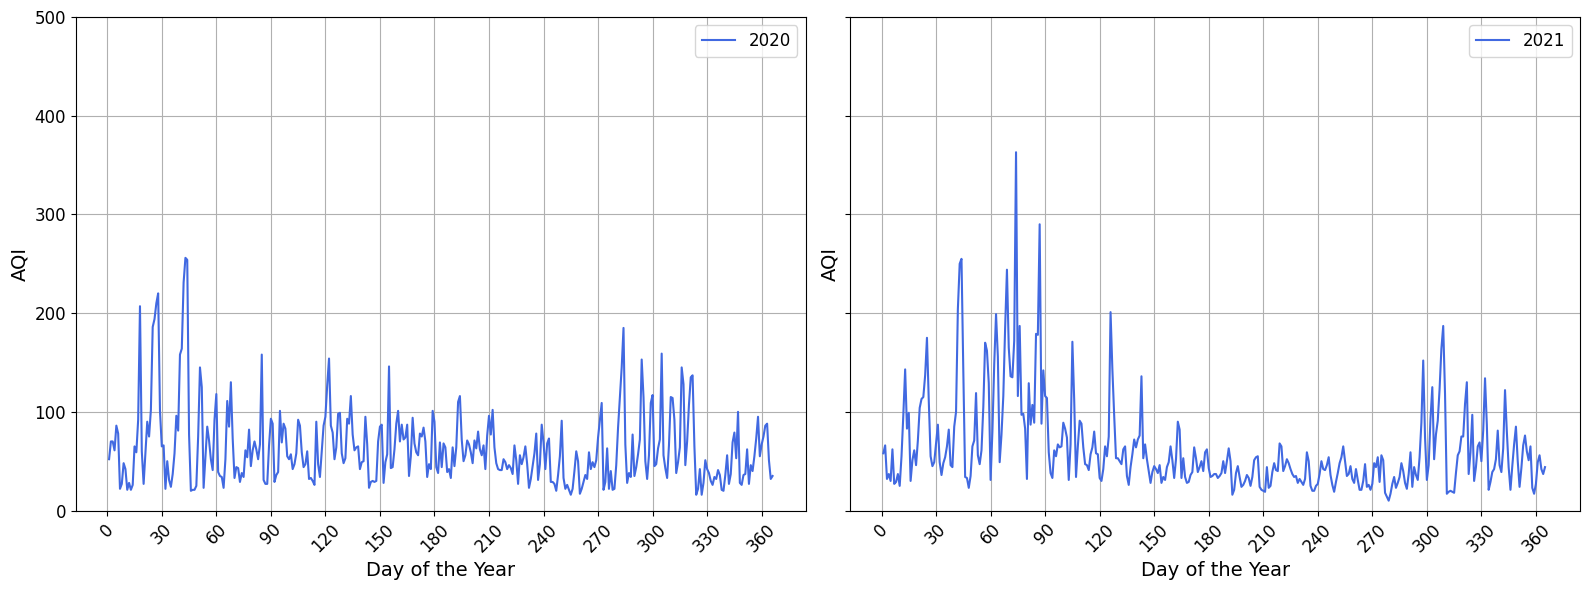

In [37]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# 定义刻度位置
x_ticks = range(0, 366, 30)

# 2020
axs[0].plot(normalized_2020.index.dayofyear, normalized_2020['AQI'], label='2020', color='royalblue')
axs[0].set_xlabel('Day of the Year', fontsize=14)
axs[0].set_ylabel('AQI', fontsize=14)
axs[0].set_xticks(x_ticks)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# 2021
axs[1].plot(normalized_2021.index.dayofyear, normalized_2021['AQI'], label='2021', color='royalblue')
axs[1].set_xlabel('Day of the Year', fontsize=14)
axs[1].set_ylabel('AQI', fontsize=14)
axs[1].set_xticks(x_ticks)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True)

# Setting the y-axis limit for all plots
for ax in axs.flat:
    ax.set_ylim(0, 500)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, rotation=45, fontsize=12)  # 旋转x轴标签并放大

plt.tight_layout()
output_path = 'C:/Users/Liu/Downloads/8_dissertation/combined_2020_2021.png'
plt.savefig(output_path)
plt.show()


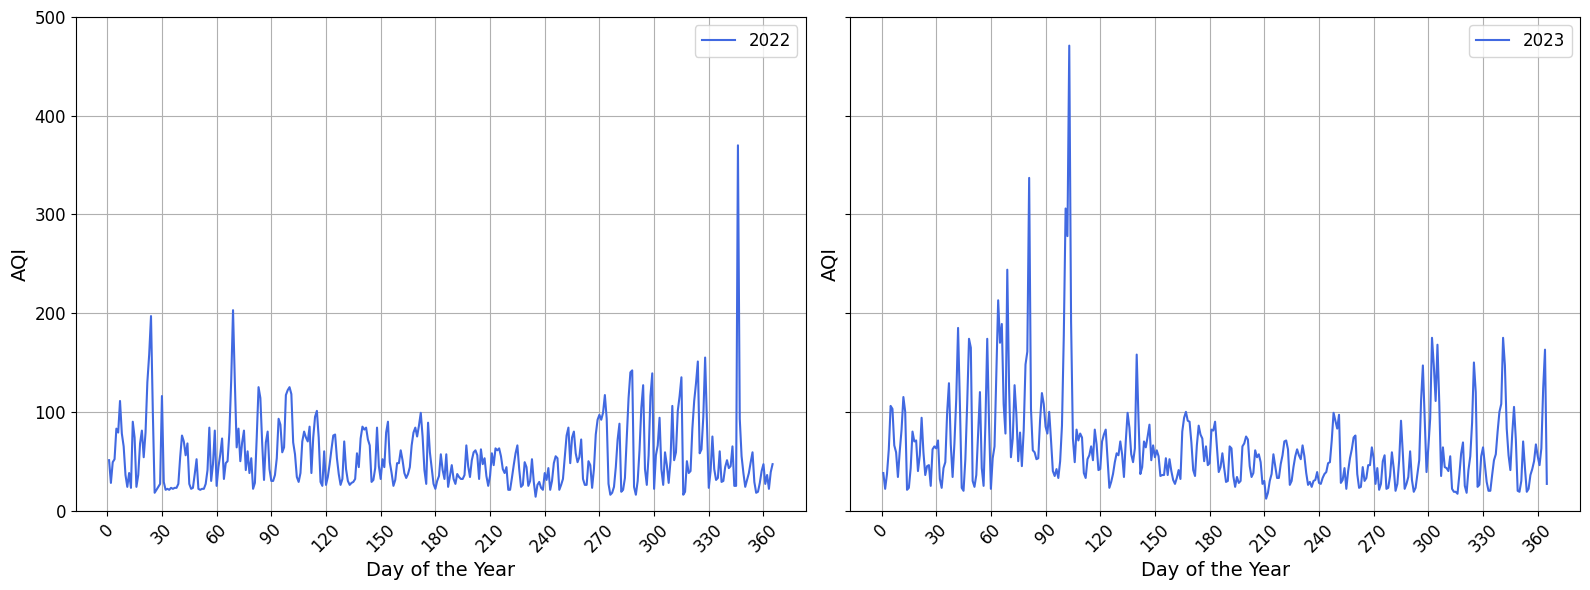

In [38]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# 定义刻度位置
x_ticks = range(0, 366, 30)

# 2022
axs[0].plot(normalized_2022.index.dayofyear, normalized_2022['AQI'], label='2022', color='royalblue')
axs[0].set_xlabel('Day of the Year', fontsize=14)
axs[0].set_ylabel('AQI', fontsize=14)
axs[0].set_xticks(x_ticks)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# 2023
axs[1].plot(normalized_2023.index.dayofyear, normalized_2023['AQI'], label='2023', color='royalblue')
axs[1].set_xlabel('Day of the Year', fontsize=14)
axs[1].set_ylabel('AQI', fontsize=14)
axs[1].set_xticks(x_ticks)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True)

# Setting the y-axis limit for all plots
for ax in axs.flat:
    ax.set_ylim(0, 500)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, rotation=45, fontsize=12)  # 旋转x轴标签并放大

plt.tight_layout()
output_path = 'C:/Users/Liu/Downloads/8_dissertation/combined_2022_2023.png'
plt.savefig(output_path)
plt.show()


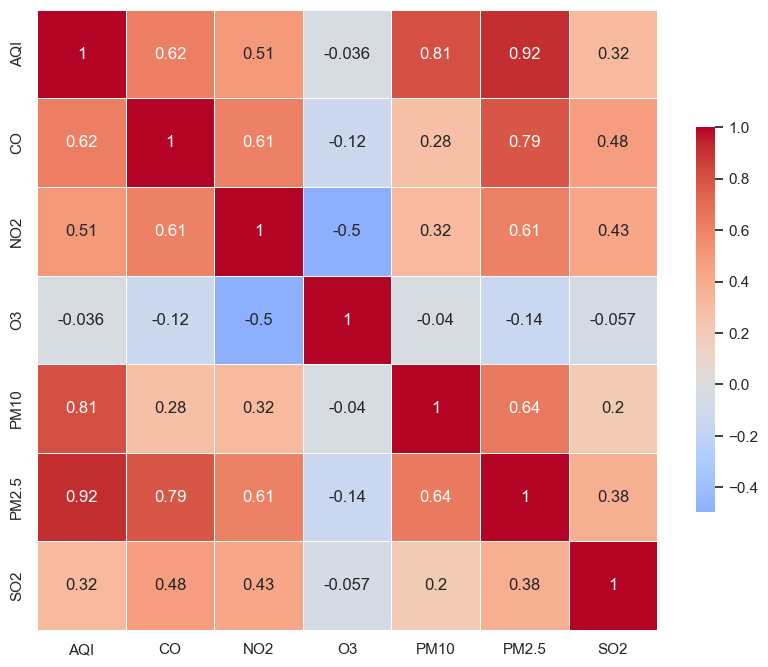

In [58]:
# 计算相关矩阵
corr_matrix = data[['AQI', 'CO', 'NO2', 'O3', 'PM10', 'PM2.5', 'SO2']].corr()

# 设置热力图的风格
sns.set(style="white")
cmap = 'coolwarm'

# 绘制热力图
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap=cmap, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 保存图像到指定路径
output_path = 'C:/Users/Liu/Downloads/8_dissertation/pollutants_corrlation_matrix.png'
plt.savefig(output_path)

# 显示热力图
plt.show()

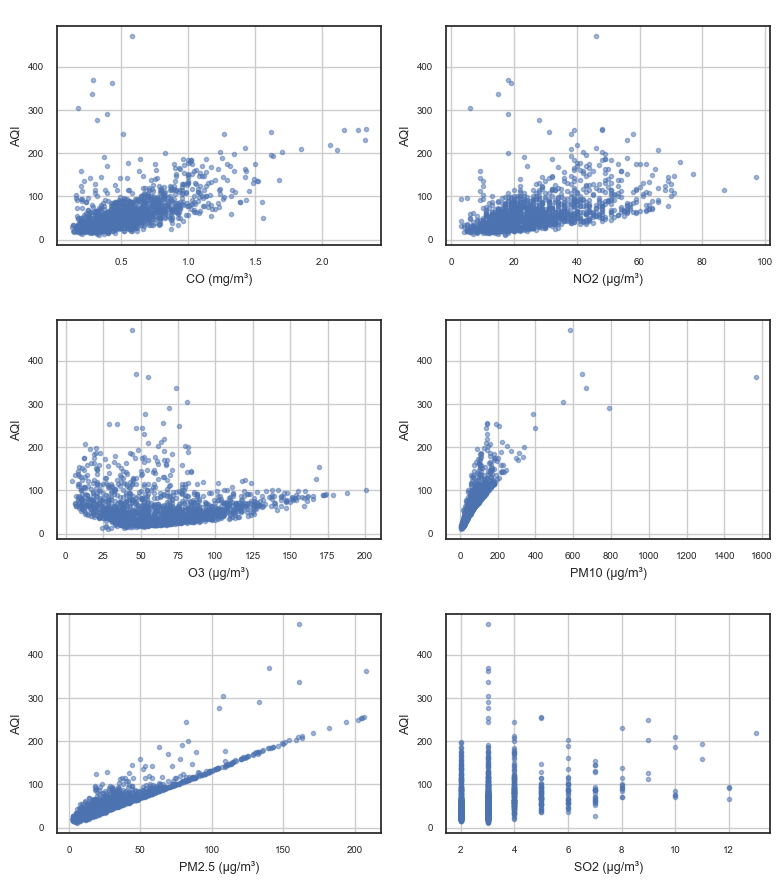

In [59]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 9))

title_fontsize = 8
label_fontsize = 9
ticks_fontsize = 7
point_size = 9

# 子图1
axs[0, 0].scatter(data['CO'], data['AQI'], alpha=0.5, s=point_size)
axs[0, 0].set_title(' ', fontsize=title_fontsize)
axs[0, 0].set_xlabel('CO (mg/m³)', fontsize=label_fontsize)
axs[0, 0].set_ylabel('AQI', fontsize=label_fontsize)
axs[0, 0].grid(True)
axs[0, 0].tick_params(labelsize=ticks_fontsize)

# 子图2
axs[0, 1].scatter(data['NO2'], data['AQI'], alpha=0.5, s=point_size)
axs[0, 1].set_title(' ', fontsize=title_fontsize)
axs[0, 1].set_xlabel('NO2 (μg/m³)', fontsize=label_fontsize)
axs[0, 1].set_ylabel('AQI', fontsize=label_fontsize)
axs[0, 1].grid(True)
axs[0, 1].tick_params(labelsize=ticks_fontsize)

# 子图3
axs[1, 0].scatter(data['O3'], data['AQI'], alpha=0.5, s=point_size)
axs[1, 0].set_title(' ', fontsize=title_fontsize)
axs[1, 0].set_xlabel('O3 (μg/m³)', fontsize=label_fontsize)
axs[1, 0].set_ylabel('AQI', fontsize=label_fontsize)
axs[1, 0].grid(True)
axs[1, 0].tick_params(labelsize=ticks_fontsize)

# 子图4
axs[1, 1].scatter(data['PM10'], data['AQI'], alpha=0.5, s=point_size)
axs[1, 1].set_title(' ', fontsize=title_fontsize)
axs[1, 1].set_xlabel('PM10 (μg/m³)', fontsize=label_fontsize)
axs[1, 1].set_ylabel('AQI', fontsize=label_fontsize)
axs[1, 1].grid(True)
axs[1, 1].tick_params(labelsize=ticks_fontsize)

# 子图5
axs[2, 0].scatter(data['PM2.5'], data['AQI'], alpha=0.5, s=point_size)
axs[2, 0].set_title(' ', fontsize=title_fontsize)
axs[2, 0].set_xlabel('PM2.5 (μg/m³)', fontsize=label_fontsize)
axs[2, 0].set_ylabel('AQI', fontsize=label_fontsize)
axs[2, 0].grid(True)
axs[2, 0].tick_params(labelsize=ticks_fontsize)

# 子图6
axs[2, 1].scatter(data['SO2'], data['AQI'], alpha=0.5, s=point_size)
axs[2, 1].set_title(' ', fontsize=title_fontsize)
axs[2, 1].set_xlabel('SO2 (μg/m³)', fontsize=label_fontsize)
axs[2, 1].set_ylabel('AQI', fontsize=label_fontsize)
axs[2, 1].grid(True)
axs[2, 1].tick_params(labelsize=ticks_fontsize)
# 保存图像到指定路径
output_path = 'C:/Users/Liu/Downloads/8_dissertation/pollutant_scatter_plot.png'
plt.savefig(output_path)
plt.tight_layout()
plt.show()

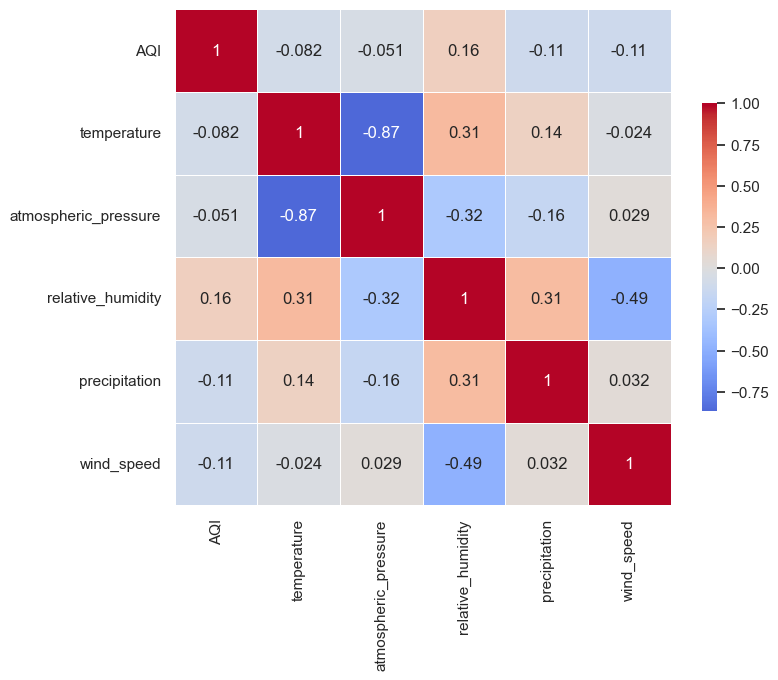

In [52]:

# 计算相关矩阵
corr_matrix = data[['AQI', 'temperature', 'atmospheric_pressure', 'relative_humidity', 'precipitation', 'wind_speed']].corr()

# 设置热力图的风格
sns.set(style="white")
cmap = 'coolwarm'

# 绘制热力图
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap=cmap, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 保存图像到指定路径
output_path = 'C:/Users/Liu/Downloads/8_dissertation/factors_matrix.png'
plt.savefig(output_path)

# 显示热力图
plt.show()